In [3]:
import os
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple
import tqdm
import matplotlib.pyplot as plt
import gym
import numpy as np

### Reply Buffer

In [51]:
Batch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones')
)


class ReplayMemory:
    def __init__(self, max_size, state_size):
        """Replay memory implemented as a circular buffer.

        Experiences will be removed in a FIFO (First in First Out) manner after reaching maximum
        buffer size.

        Args:
            - max_size: Maximum size of the buffer.
            - state_size: Size of the state-space features for the environment.
        """
        self.max_size = max_size
        self.state_size = state_size

        # preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1), dtype=torch.bool)

        # pointer to the current location in the circular buffer
        self.idx = 0
        # indicates number of transitions currently stored in the buffer
        self.size = 0

    def add(self, state, action, reward, next_state, done):
        """Add a transition to the buffer.

        :param state:  1-D np.ndarray of state-features.
        :param action:  integer action.
        :param reward:  float reward.
        :param next_state:  1-D np.ndarray of state-features.
        :param done:  boolean value indicating the end of an episode.
        """

        # YOUR CODE HERE:  store the input values into the appropriate
        # attributes, using the current buffer position `self.idx`
        self.states[self.idx] = torch.tensor(state, dtype=torch.float)
        self.actions[self.idx] = torch.tensor(action, dtype=torch.long)
        self.rewards[self.idx] = torch.tensor(reward, dtype=torch.float)
        self.next_states[self.idx] = torch.tensor(next_state, dtype=torch.float)
        self.dones[self.idx] = torch.tensor(done, dtype=torch.bool)
        
        # circulate the pointer to the next position
        self.idx = (self.idx + 1) % self.max_size
        # update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> Batch:
        """Sample a batch of experiences.

        If the buffer contains less that `batch_size` transitions, sample all
        of them.

        :param batch_size:  Number of transitions to sample.
        :rtype: Batch
        """

        # YOUR CODE HERE:  randomly sample an appropriate number of
        # transitions *without replacement*.  If the buffer contains less than
        # `batch_size` transitions, return all of them.  The return type must
        # be a `Batch`.
        if self.size < batch_size:
            sample_indices = list(range(self.size))
        else:
            sample_indices = np.random.choice(self.size, size=batch_size, replace=False)
        # Create a Batch namedtuple with sampled data
        batch = Batch(
            states=self.states[sample_indices],
            actions=self.actions[sample_indices],
            rewards=self.rewards[sample_indices],
            next_states=self.next_states[sample_indices],
            dones=self.dones[sample_indices])

        return batch

    def populate(self, env, num_steps):
        """Populate this replay memory with `num_steps` from the random policy.

        :param env:  Openai Gym environment
        :param num_steps:  Number of steps to populate the
        """
        state = env.reset()
        for _ in range(num_steps):
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            self.add(
            state=env.reset() if done else next_state,
            action=action,
            reward=reward,
            next_state=next_state,
            done=done)

### Deuling Double Deep Q learning

In [52]:

class DuelingDDQN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=256):
        super().__init__()

        self.feature_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )

        # State-value stream
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

        # Advantage-value stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        self.optimizer = optim.Adam(self.parameters())
        self.loss = nn.MSELoss()
    def forward(self, x):
        # Feature extraction
        x = self.feature_layer(x)

        # State-value
        value = self.value_stream(x)

        # Advantage-values
        advantage = self.advantage_stream(x)

        return value,advantage


In [53]:
def epsilon_greedy_action(env, model, state, epsilon):
    """
    Selects an action using epsilon-greedy strategy.

    Args:
        - model: The DQN model
        - state: The current state of the environment
        - epsilon: The exploration-exploitation trade-off parameter

    Returns:
        - action: The selected action
    """
    num = torch.rand(1).item()
    
    if num < epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            _,advantage = model.forward(torch.tensor(state, dtype=torch.float32))
        action = torch.argmax(advantage).item()

    return action

In [54]:
# This needs continuous count

class ExponentialSchedule:
    def __init__(self, value_from, value_to, num_steps):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        $value(t) = a \exp (b t)$

        :param value_from: initial value
        :param value_to: final value
        :param num_steps: number of steps for the exponential schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps
        self.a = value_from
        self.b = np.log(value_to / value_from) / (num_steps-1)

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to`interpolated value between.

        returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }

        :param step:  The step at which to compute the interpolation.
        :rtype: float.  The interpolated value.
        """

        # YOUR CODE HERE:  implement the schedule rule as described in the docstring,
        # using attributes `self.a` and `self.b`.
        if step <= 0:
            value = self.value_from
        elif step >= self.num_steps - 1:
            value = self.value_to
        else:
            value = self.a * np.exp(self.b * step)
        
        return value

In [55]:
def train_dqn_batch(optimizer, batch, Dddqn_eval, Dddqn_next, gamma) -> float:

    states = batch.states
    actions = batch.actions
    rewards = batch.rewards
    dones = batch.dones
    next_states = batch.next_states

    V_s , A_s = Dddqn_eval.forward(states)
    V_s_, A_s_ = Dddqn_next.forward(next_states)
    V_s_eval, A_s_eval = Dddqn_eval.forward(next_states)

    q_pred = torch.add(V_s,(A_s-A_s.mean(dim=1,keepdim=True))).gather(1,actions)
    q_next = torch.add(V_s_,(A_s_ - A_s_.mean(dim=1,keepdim=True)))
    q_eval = torch.add(V_s_eval,(A_s_eval - A_s_eval.mean(dim=1,keepdim=True)))
    max_actions = torch.argmax(q_eval,dim=1,keepdim=True)
    target_values = rewards + gamma * q_next.gather(1,max_actions)*(1 - dones.int())
    target_values = target_values.detach()

    # computing the scalar MSE loss between computed values and the TD-target
    loss = F.mse_loss(q_pred, target_values)

    optimizer.zero_grad()  # reset all previous gradients
    loss.backward()  # compute new gradients
    optimizer.step()  # perform one gradient descent step

    return loss.item()

In [56]:
def ddqn(env,n_episodes,replay_size,replay_prepopulate_steps,batch_size,exploration,gamma):

    # Plot returns of each episode and length of each episode

    returns = []
    lengths = []
    continuous_counter = 0

    # get the state_size from the environment
    state_size = env.observation_space.shape[0]

    # initialize the DQN and DQN-target models
    Dddqn_eval = DuelingDDQN(state_size, env.action_space.n)
    Dddqn_next = DuelingDDQN(state_size, env.action_space.n)
    Dddqn_next.load_state_dict(Dddqn_eval.state_dict())

    # initialize the optimizer
    optimizer = torch.optim.Adam(Dddqn_eval.parameters())

    # initialize the replay memory and prepopulate it
    memory = ReplayMemory(replay_size, state_size)
    memory.populate(env, replay_prepopulate_steps)
    pbar = tqdm.trange(n_episodes)
    for i_episode in pbar:
        done = False
        state = env.reset()
        rewards_list = []
        episode_timestep = 0
        while not done:
            epsilon = exploration.value(continuous_counter)
            action = epsilon_greedy_action(env, Dddqn_eval, state, epsilon)
            next_state, reward, done, _ = env.step(action)
            rewards_list.append(reward)
            memory.add(state, action, reward, next_state, done)
            
            if (continuous_counter + 1) % 4 == 0:
                batch = memory.sample(batch_size)
                loss = train_dqn_batch(optimizer, batch, Dddqn_eval, Dddqn_next, gamma)
                
            if (continuous_counter+1) % 10_000 == 0:
                Dddqn_next.load_state_dict(Dddqn_eval.state_dict())

            state = next_state
            continuous_counter +=1
            episode_timestep += 1
        
        lengths.append(episode_timestep)
        G = sum(rewards_list * (gamma ** np.arange(episode_timestep-1, -1, -1)))
        returns.append(G)

        pbar.set_description(
                f'Episode: {i_episode} | Steps: {episode_timestep} | Return: {G:5.2f} | Epsilon: {epsilon:4.2f}'
            )
    return (np.array(returns),np.array(lengths))

In [57]:
env = gym.make('LunarLander-v2')
gamma = 0.99

num_episodes = 6000

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.01, 1_000_000)

returns, lengths= ddqn(env = env,
    n_episodes=num_episodes,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma)

Episode: 5999 | Steps: 157 | Return: 185.54 | Epsilon: 0.01: 100%|██████████| 6000/6000 [1:04:31<00:00,  1.55it/s]  


In [59]:
np.save('Dddqn_lengths.npy',lengths)
np.save('Dddqn_rewards.npy',returns)

In [61]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

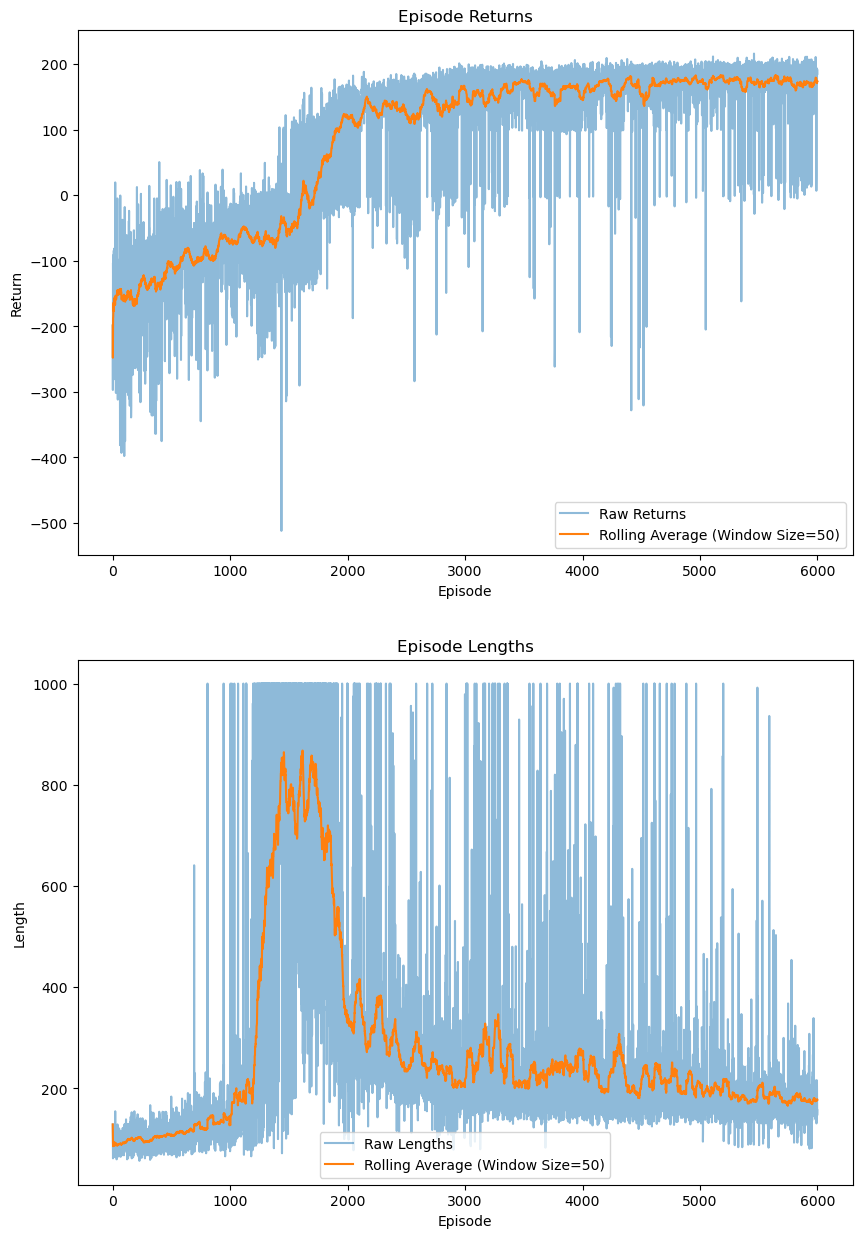

In [62]:
def plots(returns, lengths, window_size):
    # Calculate rolling averages
    smooth_returns = rolling_average(returns, window_size=window_size)
    smooth_lengths = rolling_average(lengths, window_size=window_size)

    fig, axes = plt.subplots(2, 1, figsize=(10, 15))

    # Plot Returns
    axes[0].plot(returns, label='Raw Returns', alpha=0.5)
    axes[0].plot(smooth_returns, label=f'Rolling Average (Window Size={window_size})')
    axes[0].set_title('Episode Returns')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Return')
    axes[0].legend()

    # Plot Lengths
    axes[1].plot(lengths, label='Raw Lengths', alpha=0.5)
    axes[1].plot(smooth_lengths, label=f'Rolling Average (Window Size={window_size})')
    axes[1].set_title('Episode Lengths')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Length')
    axes[1].legend()
    plt.show()
plots(returns, lengths, 5_0)

In [4]:
returns = np.load('Dddqn_rewards.npy')
print('The max return is: ')
print(returns.max())
print('Maximum length :')
print(returns.min())
returns[-1:4000:-1].mean()

The max return is: 
216.4380070856016
Maximum length :
-512.0662397276867


170.8458608644516